In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [143]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [16]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [17]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [18]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [20]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [25]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

<AxesSubplot:title={'center':'Precipitation in Last 12 Monthds'}, xlabel='Date', ylabel='Inches'>

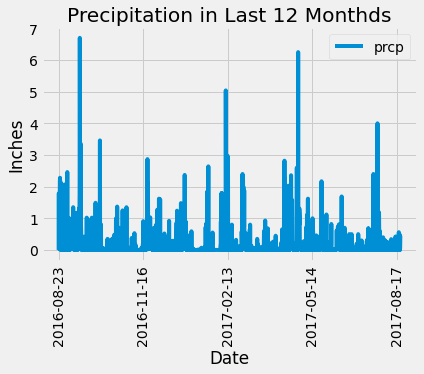

In [142]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = session.query(Measurement.date).\
                order_by(Measurement.date.desc()).\
                first()[0].\
                split("-")
# Calculate the date one year from the last date in data set.
recent_date = dt.date(int(recent_date[0]), int(recent_date[1]), int(recent_date[2]))
one_year_ago = recent_date - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
prcep_query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago)

# Save the query results as a Pandas DataFrame and set the index to the date column
prcep_df = pd.read_sql(prcep_query.statement, session.bind, index_col="date")
# Sort the dataframe by date
sorted_prcep_df = prcep_df.sort_values(by="date").dropna()
# Use Pandas Plotting with Matplotlib to plot the data
sorted_prcep_df.plot(title="Precipitation in Last 12 Monthds", rot=90, ylabel="Inches", xlabel="Date")




In [96]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_prcep_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [105]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.station).count()

9

In [120]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
active_stations_desc = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
# List the stations and the counts in descending order.
active_station = active_stations_desc[0][0]
active_stations_desc

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [134]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#temperature_range = session.query(Measurement.tobs).filter(Measurement.station == active_station).all()
#min_temp = min(temperature_range)
#max_temp = max(temperature_range)
min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == active_station).all()
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == active_station).all()
average_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == active_station).all()

[(85.0)]

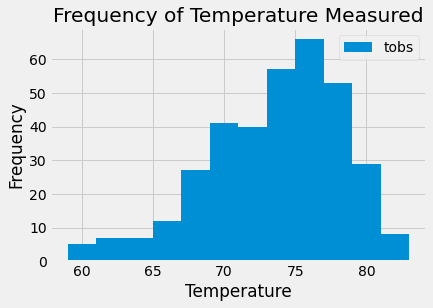

In [140]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_query = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= one_year_ago).\
    filter(Measurement.station == active_station)

tobs_df = pd.read_sql(tobs_query.statement, session.bind, index_col="date")
plt.hist(tobs_df["tobs"],12,label="tobs")
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.title("Frequency of Temperature Measured")
plt.legend()
plt.show()

# Close session

In [144]:
# Close Session
session.close()